# Preparing Data 4 the AE

### Import and function definition

In [1]:
import pandas as pd
import numpy as np
import timeit, math, os, copy, yaml, ast
import runregistry
from omsapi import OMSAPI
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.optimize import curve_fit
#%load_ext memory_profiler

In [2]:
def Make_img(histo, Xbins, Xmin, Xmax, Ybins, Ymin, Ymax):
    img = np.zeros((100, 100), dtype=np.float32)
    
    for i in range(int(Ybins)):
        for j in range(int(Xbins)):
            img[i, j] = histo[i][j]#histo[i*(int(Xbins)+2)+j]
    #img = img[1:-1, 1:-1]
    return img
    
def Show2Dimg(img, title='CSC occupancy'):
    img_temp = copy.deepcopy(img)
    cmap = plt.cm.jet
    cmap.set_under(color='white')
    max_=np.max(img_temp)
    img_temp[img_temp==0] = np.nan
    plt.imshow(img_temp, cmap=cmap, vmin=0.0000000001, vmax=max_)
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title(title)
    plt.show()
    del img_temp
    #plt.savefig('CSC_occupancy.png')

In [3]:
def Show1Dimg(vx, vy, xfit=None, yfit=None, x=r"Lumi [10$^{33}$ cm$^{-2}$ s$^{-1}$]", y="Occupancy (Hits/LS)", eymin=4, eymax=4, marker='.', line=False):
    plt.figure(figsize=(7, 4))
    if line==True:
        plt.axvline(x=9, color='red', linestyle='--')
    plt.plot(vx, vy, marker=marker, linestyle='', markersize=5, label='Data')
    if yfit is not None:
        plt.plot(xfit, yfit, color='red', label='Fit')
        plt.legend()
    plt.xlabel(x, size='14')
    plt.ylabel(y, size='14')
    plt.grid(True)
    plt.ticklabel_format(axis="y", style="sci", scilimits=(eymin,eymax))
    plt.rc('xtick', labelsize='12')
    plt.rc('ytick', labelsize='12')
    plt.title(r'$\mathbf{CMS}\ \mathit{Private\ work}$', x=0.24, y=1.0, size=14)
    #plt.title('CMS', fontweight='bold',x=0.12, y=1.0, size=14)
    plt.title('2023 (13.6 TeV)',loc='right', size=14)
    plt.legend()
    plt.show()

In [11]:
me = "hRHGlobalm3"
monitoring_elements = pd.read_parquet(me+'_files_p1.parquet')

### Occupancy Plots

#### Occupancy vs Lumi

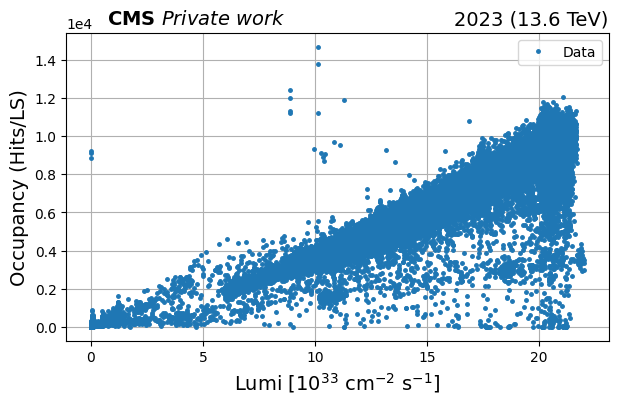

In [13]:
Show1Dimg(monitoring_elements['mean_lumi'], monitoring_elements['entries'])

### Sum over LS

Mean lumi: 0.595780814107


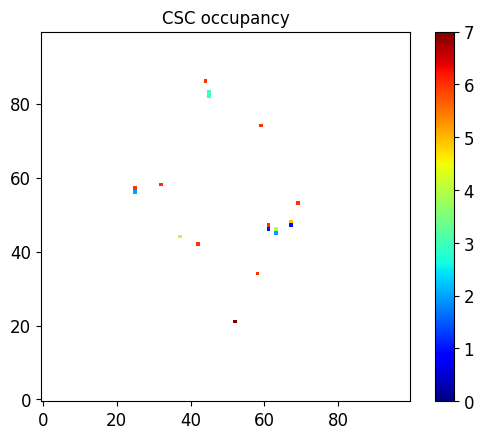

Mean lumi: 20.042941861979


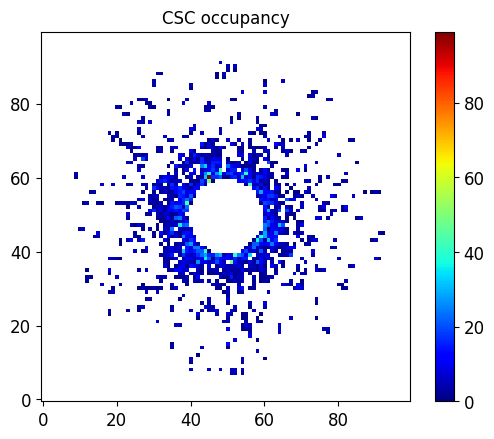

In [14]:
print("Mean lumi:", monitoring_elements["mean_lumi"][0])
img = Make_img(monitoring_elements['data'][0], monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(img)
print("Mean lumi:", monitoring_elements["mean_lumi"][2000])
img = Make_img(monitoring_elements['data'][2000], monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(img)

In [15]:
def hadd_img(df):
    count = 0
    summed_img = []
    summed_lumi = []
    summed_entries = []
    summed_number = []
    dfs = []
    count = 0
    for it in range(len(df)):
        new_row = {'data': df['data'][it], 'lumi': df['mean_lumi'][it], 'entries': df['entries'][it]}
        dfs.append(new_row)
        count +=1
        df_temp = pd.DataFrame(dfs)
        sumlumi = sum(df_temp['lumi'])
        if sumlumi > 200:
            sumdata = sum(df_temp['data'])
            summed_img.append(Make_img(sumdata, df['x_bin'][0], df['x_min'][0], df['x_max'][0], df['y_bin'][0], df['y_min'][0], df['y_max'][0]))
            summed_lumi.append(sumlumi)
            summed_entries.append(sum(df_temp['entries']))
            summed_number.append(count)
            count = 0
            dfs = []
            del sumdata
        del df_temp
        del sumlumi
        del new_row
    print("Total imgs: ",len(summed_img))
    return summed_img, summed_lumi, summed_entries, summed_number


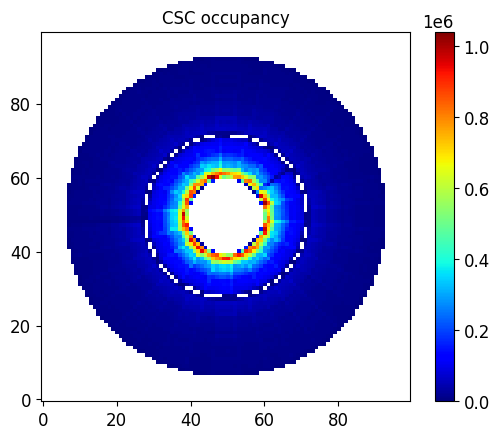

In [16]:
sum_img = Make_img(sum(monitoring_elements['data']), monitoring_elements['x_bin'][0], monitoring_elements['x_min'][0], monitoring_elements['x_max'][0], monitoring_elements['y_bin'][0], monitoring_elements['y_min'][0], monitoring_elements['y_max'][0])
Show2Dimg(sum_img)

In [17]:
imgs, lumis, entry, num = hadd_img(monitoring_elements)

Total imgs:  4321


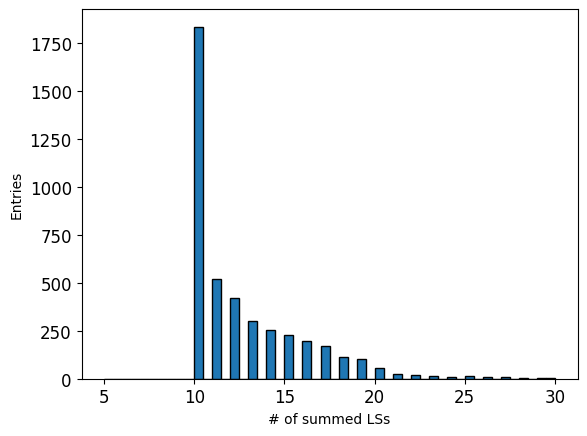

In [18]:
plt.hist(num, bins=50, range=(5, 30), edgecolor='black')
plt.xlabel('# of summed LSs')
plt.ylabel('Entries')
plt.show()

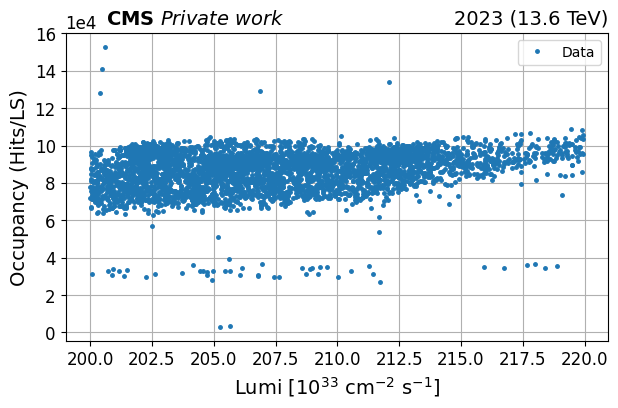

In [19]:
Show1Dimg(lumis, entry)

In [21]:
np.savez(me+'_files.npz', imgs=imgs, lumis=lumis, entry=entry, num=num)